## Este archivo corresponde a modelo V1

se importan las librerías necesarias para realizar el modelo y se define el dispositivo a utilizar (CPU o GPU).

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt
import sys

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


Se realizan tranformaciones a las imágenes para que puedan ser procesadas por el modelo preentrenado EfficientNet V2 L.

In [2]:
# Tamaño típico (puedes usar 224)
IMG_SIZE = 224

# Normalización de ImageNet
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])


### Se cargan los datos de los presents

In [3]:
data_dir = "datos"  # carpeta raíz

train_dataset = datasets.ImageFolder(
    root=f"{data_dir}/train",
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root=f"{data_dir}/validation",
    transform=val_test_transform
)

test_dataset = datasets.ImageFolder(
    root=f"{data_dir}/test",
    transform=val_test_transform
)

# 🔹 Clases detectadas por PyTorch
print("Clases (en orden):", train_dataset.classes)

num_classes = len(train_dataset.classes)
print("Número de clases:", num_classes)

# Configuración de DataLoaders

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Clases (en orden): ['carrot', 'chilli pepper', 'corn', 'cucumber', 'jalepeno']
Número de clases: 5


### Preentrenamiento del modelo EfficientNet V2 L y ajuste de la capa final para clasificación de 5 clases.

In [4]:
# Cargar modelo preentrenado
model = models.efficientnet_v2_s(pretrained=True)

# Opcional: congelar características (para entrenar solo el clasificador)
for param in model.features.parameters():
    param.requires_grad = False

# Revisar el clasificador original
print(model.classifier)

# Adaptar la última capa (classifier[1]) al número de clases
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

model = model.to(device)
print(model.classifier)


/home/yostin/Repositorios_Externos/ia_proyecto_3/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yostin/Repositorios_Externos/ia_proyecto_3/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=5, bias=True)
)


## Curvas de perdida

Iniciando entrenamiento...
------------------------------------------------------------
Época 1/15, Batch 0/14, Loss: 0.1538
Época 1/15, Batch 10/14, Loss: 0.3215
Época 1/15:
  Train Loss: 0.1808, Train Acc: 94.52%
  Val Loss: 0.0861, Val Acc: 97.87%
------------------------------------------------------------
Época 2/15, Batch 0/14, Loss: 0.1361
Época 2/15, Batch 10/14, Loss: 0.2717
Época 2/15:
  Train Loss: 0.1919, Train Acc: 93.84%
  Val Loss: 0.0865, Val Acc: 100.00%
------------------------------------------------------------
Época 3/15, Batch 0/14, Loss: 0.1506
Época 3/15, Batch 10/14, Loss: 0.1885
Época 3/15:
  Train Loss: 0.1661, Train Acc: 95.89%
  Val Loss: 0.0914, Val Acc: 97.87%
------------------------------------------------------------
Época 4/15, Batch 0/14, Loss: 0.2101
Época 4/15, Batch 10/14, Loss: 0.1660
Época 4/15:
  Train Loss: 0.1631, Train Acc: 94.52%
  Val Loss: 0.0883, Val Acc: 100.00%
------------------------------------------------------------
Época 5/15, Ba

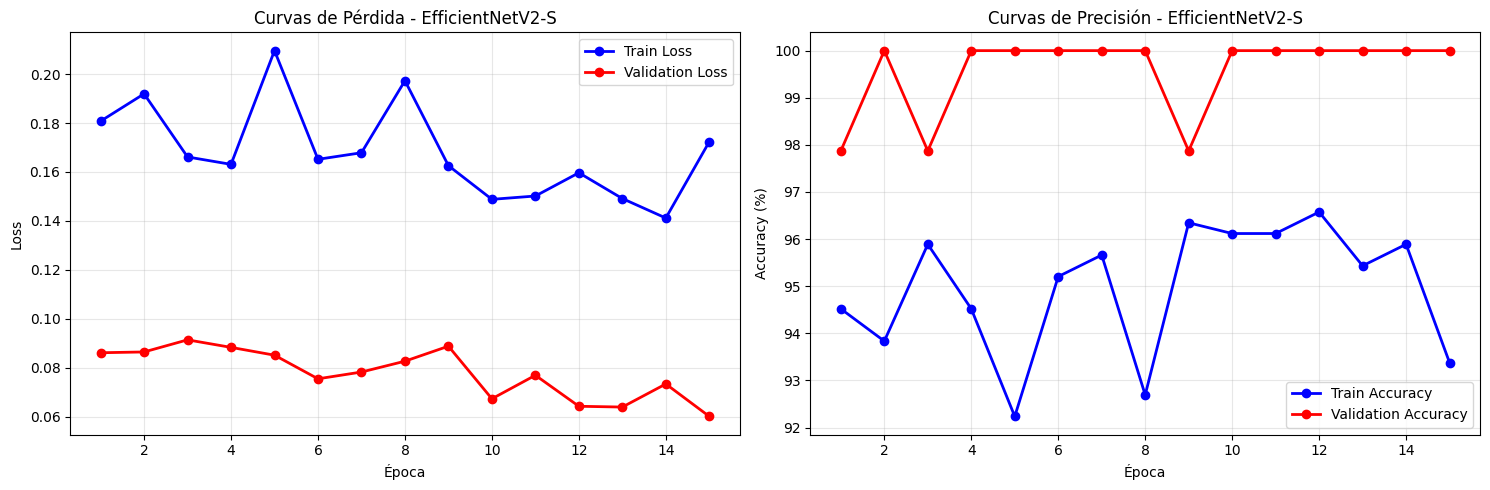


RESUMEN DEL ENTRENAMIENTO
Pérdida final de entrenamiento: 0.1724
Pérdida final de validación: 0.0601
Precisión final de entrenamiento: 93.38%
Precisión final de validación: 100.00%
Mejor precisión de validación: 100.00% (Época 2)
Menor pérdida de validación: 0.0601 (Época 15)


In [12]:
from utils.train_losses import *

# Entrenar el modelo
num_epochs = 15
learning_rate = 0.001

train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_loss_tracking(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    learning_rate=learning_rate
)

# Visualizar resultados
plot_training_curves(
    train_losses, val_losses, train_accuracies, val_accuracies,
    model_name="EfficientNetV2-S",
    save_path="curvas_entrenamiento_v1.png"
)

# Imprimir resumen
print_training_summary(train_losses, val_losses, train_accuracies, val_accuracies)

evalucion 

Matriz de confusión:
 [[10  0  0  0  0]
 [ 0 10  0  0  0]
 [ 0  0 10  0  0]
 [ 0  0  0 10  0]
 [ 0  0  0  0 10]]

Reporte por clase:
               precision    recall  f1-score   support

       carrot       1.00      1.00      1.00        10
chilli pepper       1.00      1.00      1.00        10
         corn       1.00      1.00      1.00        10
     cucumber       1.00      1.00      1.00        10
     jalepeno       1.00      1.00      1.00        10

     accuracy                           1.00        50
    macro avg       1.00      1.00      1.00        50
 weighted avg       1.00      1.00      1.00        50



In [10]:
from utils.predict_image import upload_widget, output, predecir_desde_widget 
import ipywidgets as widgets

# Crear una función wrapper para pasar los parámetros
def widget_callback(change):
    predecir_desde_widget(change, model, device, train_dataset, val_test_transform)

upload_widget.observe(widget_callback, names='value')

display(widgets.VBox([upload_widget, output]))